# Rapidez de contagio en  municipios carreteros

Un ''_municipio carretero_'' se define de la siguiente forma:
 - Tiene al menos 10\% de sus establecimientos económicos enfrente de una carretera.
 
De los 2,286 municipios hay solamente 158 municipios carreteros. En este notebook investigamos la velocidad de contagio de casos _importados_ de Covid19, medido por el número de días entre el primer contagio y el contagio del 0.01% de la población del municipio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Datos

Se usan dos tablas `casos_ajustado_poblacion.txt`, que contiene fechas semanales y bi-semanales con datos de casos de contagio de Covid. También usamos `muns_highways.tsv` que contiene la lista de los municipios carreteros.

In [320]:
pob = pd.read_csv('../data/casos_ajustado_poblacion.txt', delimiter='\t')

In [321]:
def get_only_numbers(x):
    try:
        r = int(x)
        return r
    except ValueError:
        return -1

In [322]:
def get_codes(x):
    good_codes = ['72', '461']
    x = str(x)
    for code in good_codes:
        if x.startswith(code):
            return True
        else:
            return False

In [323]:
pob = pob[['CVEGEO',
          'estado',
          'nombre',
          'poblacion_total']]

In [324]:
muns = pd.read_csv('../data/muns_highways.tsv', sep='\t')

muns  = pd.merge(muns, pob, how='left')

In [326]:
cases = pd.read_csv('../data/casos_ajustado_poblacion.txt', sep='\t')

In [327]:
dates = sorted(cases.columns[11:])

In [340]:
cas_order = cases[dates]

In [354]:
'-'.join('13-14-15'.split('-')[1:])

'14-15'

In [355]:
cas_order.columns = ['-'.join(x.split('-')[1:]) for x in cas_order.columns]

Text(0.5, 15.0, 'Fecha (Mes-día)')

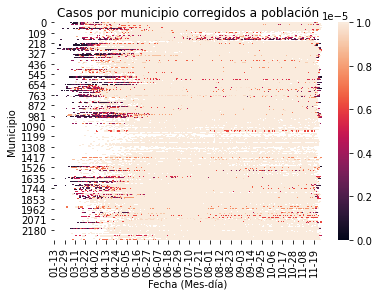

In [358]:
fig, ax = plt.subplots()
g = sns.heatmap(cas_order, vmin=0, vmax=0.00001, ax=ax)
ax.set_title('Casos por municipio corregidos a población')
ax.set_ylabel('Municipio')
ax.set_xlabel('Fecha (Mes-día)')

In [362]:
df_melt = pd.melt(cases, id_vars='CVEGEO', value_vars=dates)

In [363]:
df_pivot = pd.pivot(df_melt, columns='CVEGEO', index='variable', values='value')

In [364]:
def get_first_case(x):
    return x.first_valid_index()

In [365]:
def get_last_cumsum(x):
    return x.last_valid_index()

In [366]:
def get_date_percentage(x):
    try:
        date = x[x.gt(.0001)].index[0]
        return date
    except IndexError:
        return np.nan

In [367]:
first_cases = df_pivot.apply(get_first_case, axis=0).rename('first_case').reset_index()

df_cum = df_pivot.cumsum()

df_cumsum = df_cum.ffill(axis=0).iloc[-1,:].rename('agg_cases').reset_index()

first_cases = pd.merge(first_cases, df_cumsum, how='left')

In [368]:
muns = muns[['CVEGEO']]

muns['is_carretero'] = True

<ipython-input-368-f1652244362d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muns['is_carretero'] = True


In [369]:
first_cases = pd.merge(first_cases, muns, how='left')

first_cases['is_carretero'] = first_cases.is_carretero.fillna(False)

In [370]:
first_cases = pd.merge(first_cases, pob, how='left')

first_cases['first_case'] = pd.to_datetime(first_cases['first_case'])

first_cases['day_first_case'] = first_cases['first_case'].dt.dayofyear

df_per = df_pivot.apply(get_date_percentage, axis=0).rename('date_01').reset_index()

first_cases = pd.merge(first_cases, df_per, how='left')

first_cases['date_01'] = pd.to_datetime(first_cases.date_01)

first_cases['days_to_01'] = (first_cases['date_01'] - first_cases['first_case']).dt.days

In [376]:
cases_carr = pd.merge(cases, first_cases)

Text(0.5, 15.0, 'Fecha (Mes-día)')

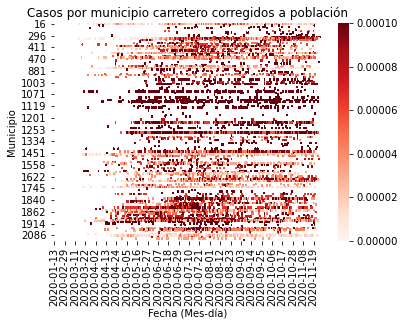

In [389]:
fig, ax = plt.subplots()
g = sns.heatmap(cases_carr[cases_carr.is_carretero==True][dates], vmin=0, vmax=0.0001, ax=ax,
               cmap=plt.cm.Reds)
ax.set_title('Casos por municipio carretero corregidos a población')
ax.set_ylabel('Municipio')
ax.set_xlabel('Fecha (Mes-día)')

Text(0.5, 15.0, 'Fecha (Mes-día)')

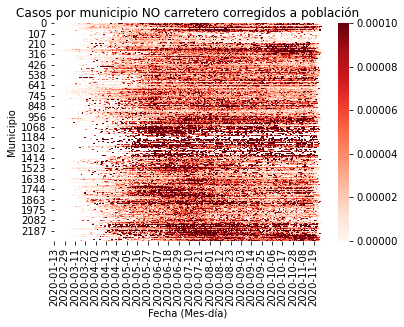

In [391]:
fig, ax = plt.subplots()
g = sns.heatmap(cases_carr[cases_carr.is_carretero==False][dates], vmin=0, vmax=0.0001, ax=ax,
               cmap=plt.cm.Reds)
ax.set_title('Casos por municipio NO carretero corregidos a población')
ax.set_ylabel('Municipio')
ax.set_xlabel('Fecha (Mes-día)')

## Tests

In [371]:
np.random.seed(42)
sample_mean = []
min_carr = 851
max_carr = 184239
not_carr = first_cases[first_cases['is_carretero'] == False]
for i in range(1000):
    idx = np.random.choice(not_carr.shape[0], muns.shape[0])
    chunk = not_carr.iloc[idx]
    sample_mean.append(chunk['days_to_01'].mean())

In [372]:
carr = first_cases[first_cases.is_carretero==True].days_to_01.mean()

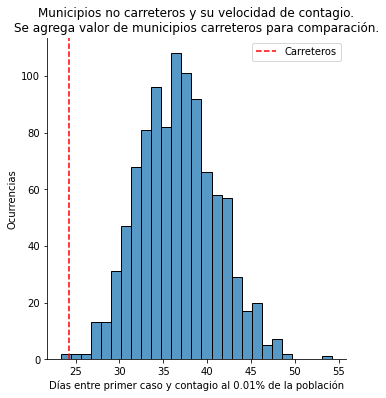

In [373]:
g = sns.displot(sample_mean)
g.axes[0,0].set_title('Municipios no carreteros y su velocidad de contagio.'
                      '\nSe agrega valor de municipios carreteros para comparación.')
g.axes[0,0].set_ylabel('Ocurrencias')
g.axes[0,0].set_xlabel('Días entre primer caso y contagio al 0.01% de la población')
g.axes[0,0].axvline(carr, linestyle='--', color='red', label='Carreteros')
g.axes[0,0].legend();

In [303]:
first_cases.to_csv('../data/municipios.tsv', index=False, sep='\t')

# Casos

In [392]:
cases = pd.read_csv('../data/factores_covid_municipio.tsv', sep='\t')

In [393]:
cases['day_10_deaths'] = pd.to_datetime(cases['day_10_deaths'])
cases['day_first_case'] = pd.to_datetime(cases['day_first_case'])
cases['day_50_cases'] = pd.to_datetime(cases['day_50_cases'])
cases['day_first_death'] = pd.to_datetime(cases['day_first_death'])

In [398]:
cases['diff_50_cases'] = (cases['day_50_cases'] - cases['day_first_case']).dt.days
cases['diff_10_deaths'] = (cases['day_10_deaths'] - cases['day_first_case']).dt.days

In [401]:
cases = cases.rename(columns={'municipality_id': 'CVEGEO'})

In [402]:
first_cases

,CVEGEO,first_case,agg_cases,is_carretero,estado,nombre,poblacion_total,day_first_case,date_01,days_to_01
0,1001,2020-03-07,0.011991,False,Aguascalientes,Aguascalientes,877190.0,67.0,2020-10-12,219.0
1,1002,2020-03-15,0.004283,False,Aguascalientes,Asientos,46464.0,75.0,2020-07-01,108.0
2,1003,2020-04-20,0.006423,False,Aguascalientes,Calvillo,56048.0,111.0,2020-07-06,77.0
3,1004,2020-05-07,0.006291,False,Aguascalientes,Cosío,15577.0,128.0,2020-05-11,4.0
4,1005,2020-03-23,0.003463,False,Aguascalientes,Jesús María,120405.0,83.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
2281,32054,2020-04-27,0.003289,False,Zacatecas,Villa Hidalgo,19155.0,118.0,2020-07-17,81.0
2282,32055,2020-03-17,0.007970,False,Zacatecas,Villanueva,30240.0,77.0,2020-09-18,185.0
2283,32056,2020-03-09,0.027992,False,Zacatecas,Zacatecas,146147.0,69.0,2020-07-10,123.0
2284,32057,2020-04-16,0.007469,False,Zacatecas,Trancoso,19413.0,107.0,2020-07-25,100.0


In [404]:
cases = cases[['CVEGEO', 'diff_50_cases', 'diff_10_deaths']]

In [405]:
first_cases = pd.merge(first_cases, cases)

In [406]:
first_cases.head()

,CVEGEO,first_case,agg_cases,is_carretero,estado,nombre,poblacion_total,day_first_case,date_01,days_to_01,diff_50_cases,diff_10_deaths
0,1001,2020-03-07,0.011991,False,Aguascalientes,Aguascalientes,877190.0,67.0,2020-10-12,219.0,23.0,53.0
1,1002,2020-03-15,0.004283,False,Aguascalientes,Asientos,46464.0,75.0,2020-07-01,108.0,119.0,NaN
2,1003,2020-04-20,0.006423,False,Aguascalientes,Calvillo,56048.0,111.0,2020-07-06,77.0,76.0,NaN
3,1004,2020-05-07,0.006291,False,Aguascalientes,Cosío,15577.0,128.0,2020-05-11,4.0,65.0,NaN
4,1005,2020-03-23,0.003463,False,Aguascalientes,Jesús María,120405.0,83.0,NaT,NaN,84.0,166.0


In [156]:
muns['is_carretero'] = True

In [159]:
muns = muns.rename(columns={'CVEGEO': 'municipality_id'})

In [161]:
muns = muns[['municipality_id', 'is_carretero']]

In [163]:
cases = pd.merge(cases, muns, how='left')

In [166]:
muns

,municipality_id,is_carretero
0,2005,True
1,5008,True
2,5012,True
3,5014,True
4,7007,True
...,...,...
153,30155,True
154,30175,True
155,30197,True
156,30210,True


In [154]:
cases

,municipality_id,municipality,max_cases,max_hospitalized,max_deaths,day_first_case,day_first_death,day_50_cases,day_10_deaths,total_cases,total_deaths,diff_50_cases,diff_10_deaths
0,1001,Aguascalientes,201,29,16,2020-03-14,2020-04-10,2020-04-06,2020-05-06,8952,852,23 days,53 days
1,1005,Jesús María,9,4,4,2020-03-23,2020-05-17,2020-06-15,2020-09-05,391,29,84 days,166 days
2,1006,Pabellón de Arteaga,12,3,3,2020-03-23,2020-05-17,2020-06-05,2020-08-29,424,27,74 days,159 days
3,1007,Rincón de Romos,14,5,2,2020-03-30,2020-06-06,2020-06-01,2020-09-20,516,16,63 days,174 days
4,1011,San Francisco de los Romo,5,2,1,2020-04-20,2020-05-07,2020-08-09,2020-10-08,112,13,111 days,171 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,32039,Río Grande,8,5,2,2020-04-29,2020-05-10,2020-07-10,2020-07-17,335,47,72 days,79 days
579,32042,Sombrerete,26,2,1,2020-03-20,2020-05-17,2020-07-31,2020-08-30,489,25,133 days,163 days
580,32050,Vetagrande,3,3,2,2020-07-07,2020-07-14,2020-11-04,2020-10-14,51,12,120 days,99 days
581,32056,Zacatecas,66,13,5,2020-03-24,2020-05-02,2020-05-22,2020-06-20,3424,234,59 days,88 days
